In [155]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import cv2

(-0.5, 767.5, 511.5, -0.5)

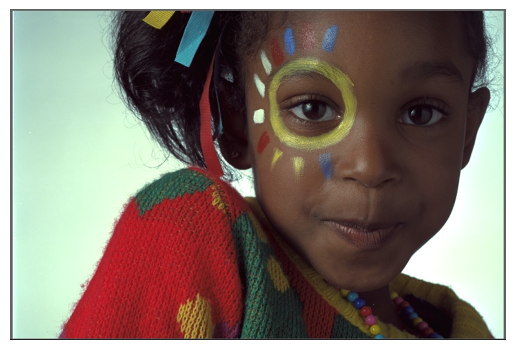

In [340]:
img_rgb = cv2.imread('Image/Some Images/kodim15.png' )
img_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)

plt.axis('off')

In [341]:
'''
Function which rake image name as input and read the image from directory Image/Some Images/ and convert into image which is 
divisible by block size by adding padding
'''

def convert_img_div_by_block_size(img, b_s, col_or_gray):
    img_rgb = cv2.imread('Image/Some Images/' + img)
    rows, cols = img_rgb.shape[0], img_rgb.shape[1]
    
    if col_or_gray == 1:
        img_yuv = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2YUV)
    else:
        img_yuv = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
    
    rows_rem = rows % b_s
    cols_rem = cols % b_s
    
    if rows_rem != 0:
        new_rows = rows + (b_s - rows_rem)
    else:
        new_rows = rows
        
    if cols_rem != 0:
        new_cols = cols + (b_s - cols_rem)
    else:
        new_cols = cols
        
    if col_or_gray == 1:     
        new_img = np.zeros(((new_rows, new_cols, 3)), dtype=np.uint8)
        new_img[:rows, :cols,:] = img_yuv
    else:
        new_img = np.zeros((new_rows, new_cols), dtype=np.uint8)
        new_img[:rows, :cols] = img_yuv
    
    
    return new_img

In [345]:
def find_zig_zag_arr(arr):
    rows, cols = arr.shape
    x,y = 0,0
    
    flag = True
    
    lst = []
    
    for i in range(rows*cols):
            lst.append(arr[x,y])
            if flag:
                if x-1 >= 0 and y+1 < cols:
                    x = x-1
                    y = y+1
                else:
                    flag = False
                    if(y+1 <cols):
                        y = y+1
                    else:
                        x = x+1
            else:
                if x+1 < rows and y-1 >= 0:
                    x = x+1
                    y = y-1
                else:
                    flag = True
                    if x+1 < rows: 
                        x = x+1
                    else:
                        y = y+1
                        
    lst = np.array(lst)
    
    return lst   

#### JPEG_encoder:
        Input:  image filename, block size, # of Coefficient parameters sent, Color/grayscale binary input
        Output: JPEG encoded integer array  //this shall also be written in some file e.g. img1_jpgcode.txt 

In [346]:
def get_quantization_mat(block_sz):
    q1 = np.array([[16, 11, 10, 16, 24, 40, 51, 61],
            [12, 12, 14, 19, 26, 48, 60, 55],
            [14, 13, 16, 24, 40, 57, 69, 56],
            [14, 17, 22, 29, 51, 87, 80, 62],
            [18, 22, 37, 56, 68, 109, 103, 77],
            [24, 35, 55, 64, 81, 104, 113, 92],
            [49, 64, 78, 87, 103, 121, 120, 101],
            [72, 92, 95, 98, 112, 100, 103, 99]], 'uint8')

    q2 = np.array([[17, 18, 24, 47, 99, 99, 99, 99],
            [18, 21, 26, 66, 99, 99, 99, 99],
            [24, 26, 56, 99, 99, 99, 99, 99],
            [47, 66, 99, 99, 99, 99, 99, 99],
            [99, 99, 99, 99, 99, 99, 99, 99],
            [99, 99, 99, 99, 99, 99, 99, 99],
            [99, 99, 99, 99, 99, 99, 99, 99],
            [99, 99, 99, 99, 99, 99, 99, 99]], 'uint8')

    q1 = cv2.resize(q1,(block_sz, block_sz))
    q2 = cv2.resize(q2,(block_sz, block_sz))
    
    return q1,q2

In [347]:
def jpeg_encoder(img, block_sz, num_coef, col_or_gray):
    img_yuv = convert_img_div_by_block_size(img, block_sz, col_or_gray)
    
    rows, cols = img_yuv.shape[0], img_yuv.shape[1]
    
    q1,q2 = get_quantization_mat(block_sz)
    
    dc_coef = []
        
    f = open('img1_jpgcode.txt ','w')
    
    if col_or_gray == 0:
        for i in range(0, rows, block_sz):
            for j in range(0, cols, block_sz):
                dc = []               
                block = np.float32(img_yuv[i:i+block_sz, j:j+block_sz])
                block = block - 128
                dct_ = cv2.dct(block)     
                q_mat = (dct_ / q1).round().astype(np.int32)  
                zig_zag_arr = find_zig_zag_arr(q_mat)                

                for dc_comp in range(num_coef):
                    dc.append(zig_zag_arr[dc_comp])
                    f.write(str(zig_zag_arr[dc_comp]) + ' ')
                dc_coef.append(dc)    
                f.write('\n')
        return dc_coef
    
    
    ch = img_yuv.shape[2]
    for i in range(0, rows, block_sz):
        for j in range(0, cols, block_sz):
            dc = []
            for c in range(ch): 
                block = np.float32(img_yuv[i:i+block_sz, j:j+block_sz, c])
                block = block - 128
                dct_ = cv2.dct(block)
                if c == 0:        
                    q_mat = (dct_ / q1).round().astype(np.int32)  
                else:
                    q_mat = (dct_ / q2).round().astype(np.int32) 
                
                zig_zag_arr = find_zig_zag_arr(q_mat)                

                for dc_comp in range(num_coef):
                    dc.append(zig_zag_arr[dc_comp])
                    f.write(str(zig_zag_arr[dc_comp]) + ' ')
            dc_coef.append(dc)    
            f.write('\n')
    return dc_coef

In [365]:
encoded_img_arr = jpeg_encoder('kodim15.png', 8,1,1)

#### JPEG_decoder:
     Input: all 4 inputs as mentioned above, JPEG encoded integer array, 
     Output: Reconstructed image, RMSE, PSNR, and compression ratio

In [349]:
def rebuild_block(block, c, num_coef, dc_comp):
    rows, cols = block.shape     
    idx = c*num_coef
    x,y = 0,0
    
    flag = True
    
    lst = []
    
    for i in range(idx, idx+num_coef, 1):
        block[x,y] = dc_comp[i]
           
        if flag:
            if x-1 >= 0 and y+1 < cols:
                x = x-1
                y = y+1
            else:
                flag = False
                if(y+1 <cols):
                    y = y+1
                else:
                    x = x+1
        else:
            if x+1 < rows and y-1 >= 0:
                x = x+1
                y = y-1
            else:
                flag = True
                if x+1 < rows: 
                    x = x+1
                else:
                    y = y+1
                    
    return block       

In [350]:
def jpeg_decoder(img, block_sz, num_coef, col_or_gray,encoded_img_arr):    
    q1,q2 = get_quantization_mat(block_sz)  
    
    img_rgb = cv2.imread('Image/Some Images/' + img)
    img_rgb = convert_img_div_by_block_size(img, block_sz, col_or_gray)
    rows, cols = img_rgb.shape[0], img_rgb.shape[1]
    
    if col_or_gray == 0:
        decode_img = np.zeros((rows,cols))
        idx = 0
        
        for i in range(0, rows, block_sz):
            for j in range(0, cols, block_sz): 
                block = np.float32(decode_img[i:i+block_sz, j:j+block_sz])
                block = rebuild_block(block,0,num_coef,encoded_img_arr[idx])
#                 print(f" i = {i}, j = {j} , block = {block}")
                block = block * q1
                block = cv2.idct(block)                
                block = block + 128
                decode_img[i:i+block_sz, j:j+block_sz] = block
                idx = idx + 1
            
        return decode_img    
            
           
    ch = img_yuv.shape[2]
    
    decode_img = np.zeros(((rows, cols, ch)))
    
    idx = 0
    
    for i in range(0, rows, block_sz):
        for j in range(0, cols, block_sz):
            for c in range(ch): 
                block = np.float32(decode_img[i:i+block_sz, j:j+block_sz, c])
                block = rebuild_block(block,c,num_coef,encoded_img_arr[idx])
                if c == 0:
                    block = block * q1
                else:
                    block = block * q2

                block = cv2.idct(block)
                
                block = block + 128

                decode_img[i:i+block_sz, j:j+block_sz, c] = block
            idx = idx + 1
            
            
    return decode_img        

In [368]:
decoded_img = jpeg_decoder('kodim15.png', 8,1,1, encoded_img_arr)

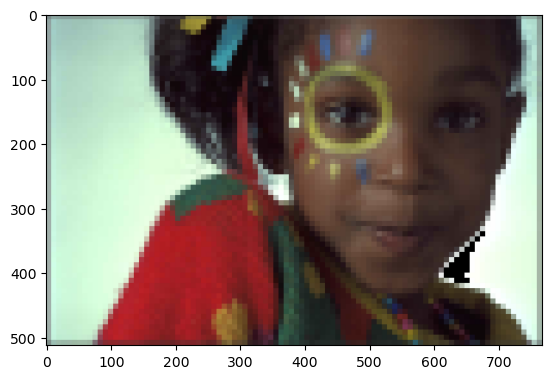

In [369]:
decoded_img = np.uint8(decoded_img)
decoded_img = cv2.cvtColor(decoded_img, cv2.COLOR_YUV2RGB)
plt.imshow(decoded_img)

##### Loading all images name for doing analysis

In [370]:
def RMSE(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    rmse = np.sqrt(mse)
    
    return rmse    

In [371]:
def PSNR(img1, img2):
    mse = np.mean((img1 - img2) ** 3)
    rmse = np.sqrt(mse)
    psnr = 20 * np.log10(255 / rmse)
    
    return psnr

In [372]:
import os

img_path = "Image/Some Images/"

img_names = []

for img in os.listdir(img_path):
    if os.path.isfile(os.path.join(img_path, img)) and img.endswith('.tif'):
        img_names.append(img)
print(img_names)             

['book-cover.tif', 'checkerboard1024.tif', 'Fig81a.tif', 'Fig81b.tif', 'Fig81c.tif', 'fingerprint.tif', 'gray_img.tif', 'lena.tif', 'matches-aligned.tif', 'matches-random.tif', 'zoneplate.tif']


In [373]:
img_path = "Image/Some Images/"

color_imgs = []

for img in os.listdir(img_path):
    if os.path.isfile(os.path.join(img_path, img)) and img.endswith('.png'):
        color_imgs.append(img)
print(color_imgs)   

['kodim01.png', 'kodim02.png', 'kodim03.png', 'kodim04.png', 'kodim05.png', 'kodim06.png', 'kodim07.png', 'kodim08.png', 'kodim09.png', 'kodim10.png', 'kodim11.png', 'kodim12.png', 'kodim13.png', 'kodim14.png', 'kodim15.png', 'kodim16.png', 'kodim17.png', 'kodim18.png', 'kodim19.png', 'kodim20.png', 'kodim21.png', 'kodim22.png', 'kodim23.png', 'kodim24.png']


(-0.5, 767.5, 511.5, -0.5)

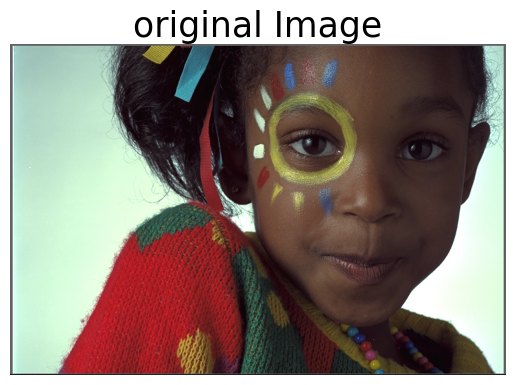

In [377]:
img_rgb = cv2.imread('Image/Some Images/' + color_imgs[14])
img_yuv = convert_img_div_by_block_size(color_imgs[14], 8,1)
img_rgb = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)

y,u,v = cv2.split(img_rgb)

plt.title(f"original Image", fontsize = 25)
plt.imshow(img_rgb)
plt.axis('off') 

8
16
24
32
40
48
56
64


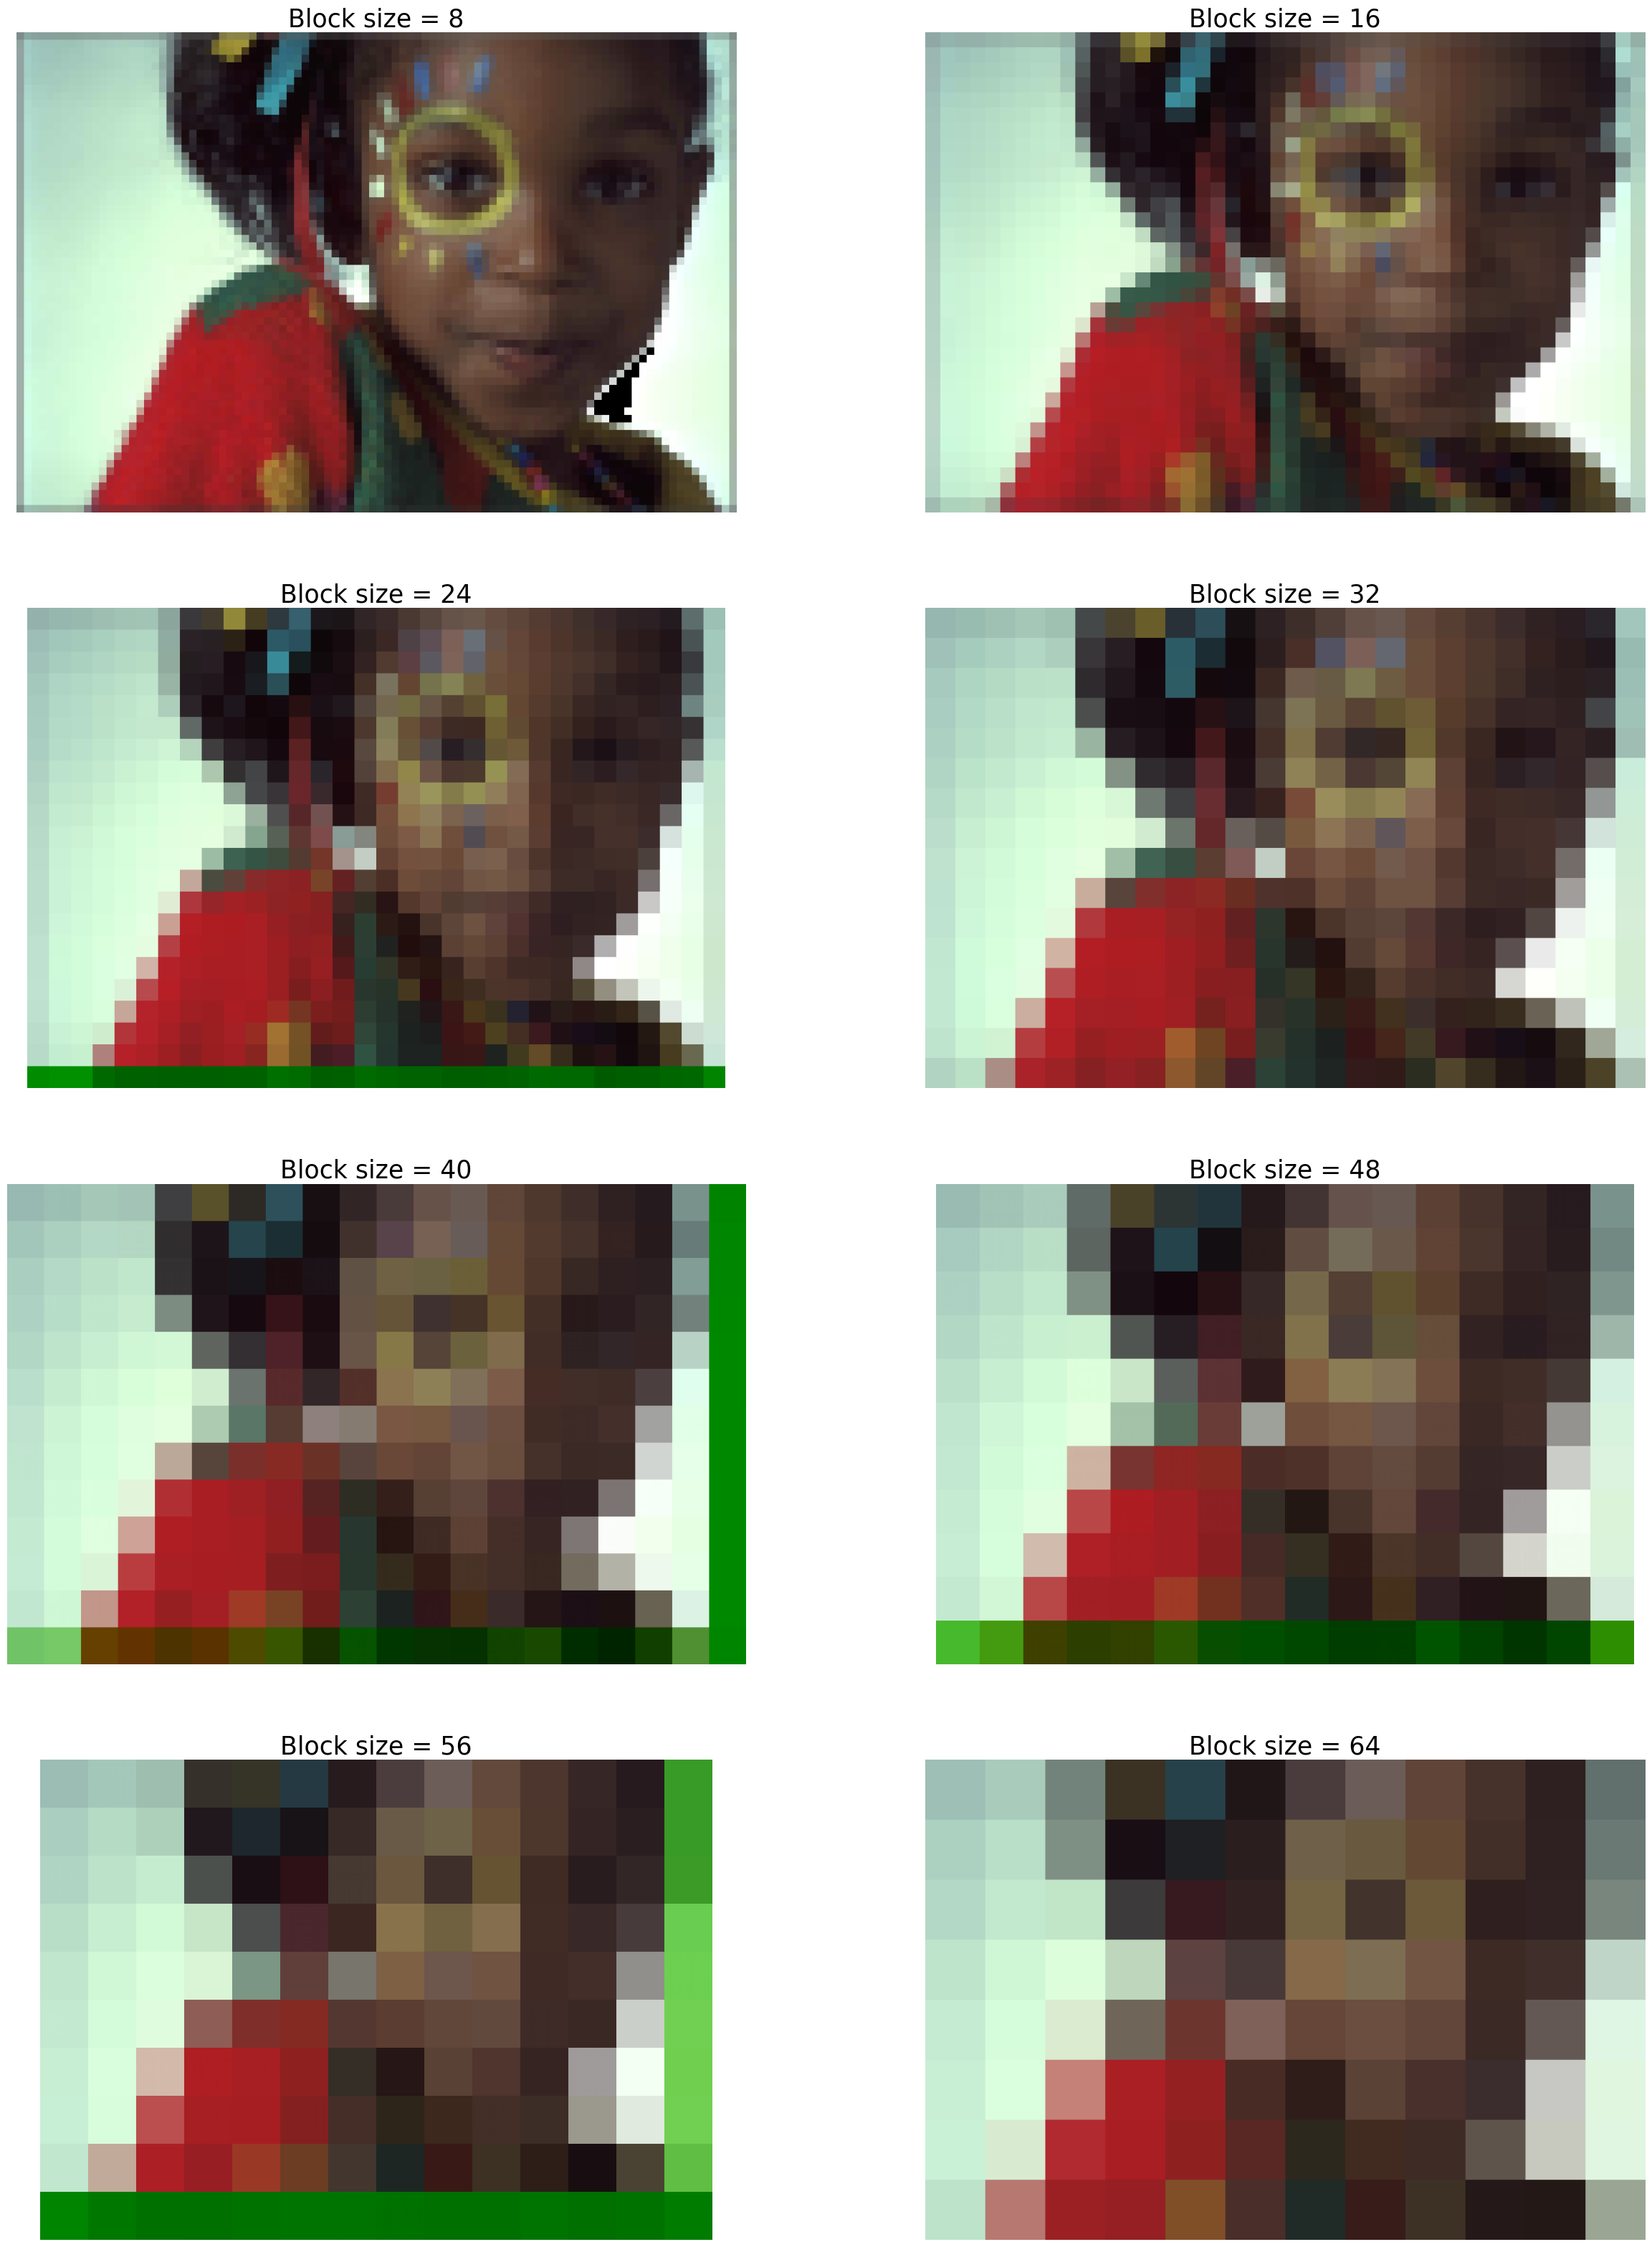

In [380]:
img_rgb = cv2.imread('Image/Some Images/' + color_imgs[14])
img_yuv = convert_img_div_by_block_size(color_imgs[14], 8,1)
img_rgb = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)

plt.figure(figsize=(30,40))
j = 1

plt.subplot(4,2,j)
plt.title(f"Original Image", fontsize = 25)
plt.imshow(img_rgb)
plt.axis('off') 

rmse_lst = []
psnr_lst = []

for blc in range(8,65,8):   
    print(blc)
    img_rgb = cv2.imread('Image/Some Images/' + color_imgs[14])
    img_yuv = convert_img_div_by_block_size(color_imgs[14], blc,1)
    img_rgb = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)
    encoded_img_arr = jpeg_encoder(color_imgs[14], blc,1,1)
    decoded_img = jpeg_decoder(color_imgs[14], blc,1,1, encoded_img_arr)
    decoded_img = np.uint8(decoded_img)
    decoded_img = cv2.cvtColor(decoded_img, cv2.COLOR_YUV2RGB)
    plt.subplot(4,2,j)
    plt.title(f"Block size = {blc}", fontsize = 25)
    plt.imshow(decoded_img)
    plt.axis('off') 
    j = j+1
    rmse = RMSE(img_rgb, decoded_img)
    psnr = PSNR(img_rgb, decoded_img)
    rmse_lst.append(rmse)
    psnr_lst.append(psnr)   

In [381]:
blc_lst = []
for blc in range(8,65,8):   
    blc_lst.append(blc)

Text(0, 0.5, 'RMSE')

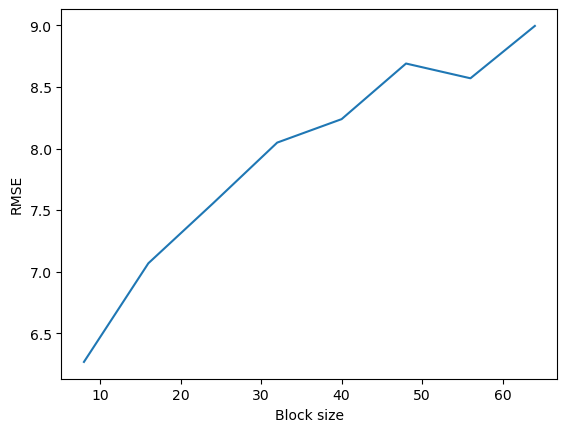

In [382]:
plt.plot(blc_lst,rmse_lst)
plt.xlabel("Block size")
plt.ylabel("RMSE")
    

Text(0, 0.5, 'psnr')

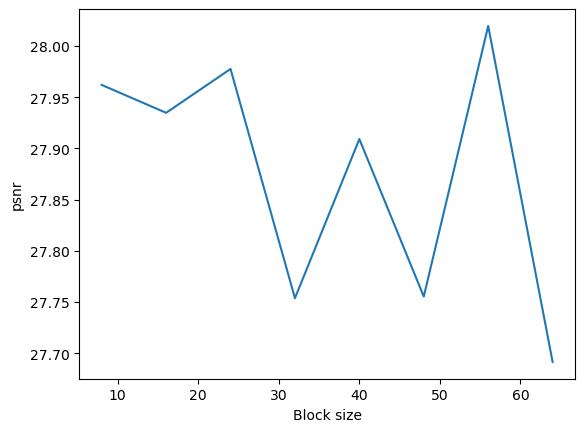

In [383]:
plt.plot(blc_lst,psnr_lst)
plt.xlabel("Block size")
plt.ylabel("psnr")

In [384]:
def comp_ratio(img,dc):
    h,w,ch = img_rgb.shape  
    a = h*w*ch
    b = (h*w) / (64)
    b *= 3
    b *= dc
    return a/b

In [386]:
comp_lst = []

h,w,ch = img_rgb.shape

for blc in range(8,65,8):   
    a = h*w*ch
    b = (h*w) / (blc*blc)
    b *= 3
    comp_lst.append(a/b)

Text(0, 0.5, 'Block size')

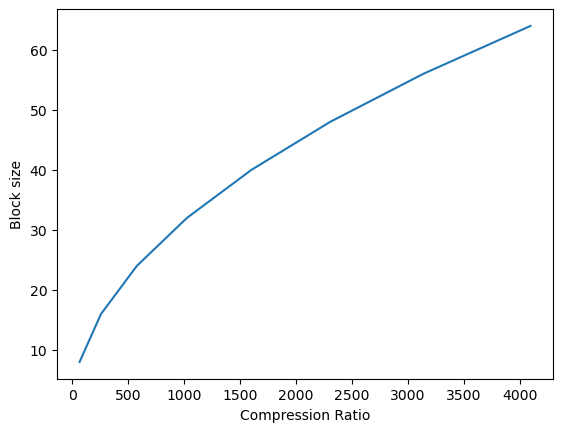

In [387]:
plt.plot(comp_lst,blc_lst)
plt.xlabel("Compression Ratio")
plt.ylabel("Block size")

Text(0, 0.5, 'RMSE')

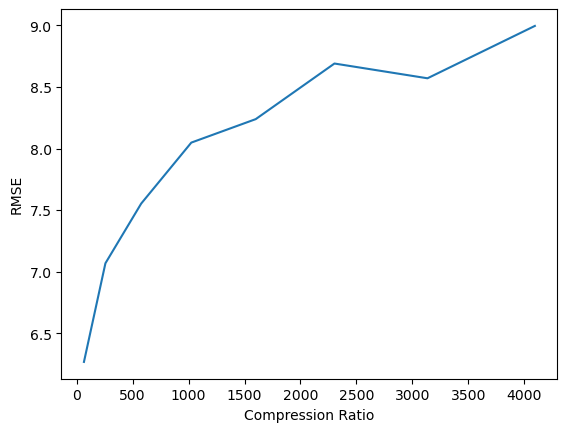

In [388]:
plt.plot(comp_lst,rmse_lst)
plt.xlabel("Compression Ratio")
plt.ylabel("RMSE")

Text(0, 0.5, 'PSNR')

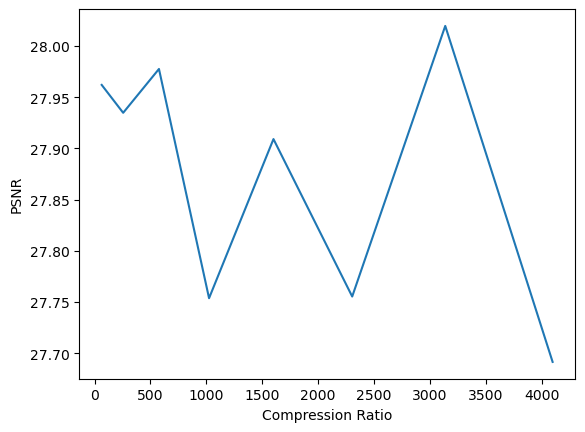

In [389]:
plt.plot(comp_lst,psnr_lst)
plt.xlabel("Compression Ratio")
plt.ylabel("PSNR")